# converted to MongoDB

In [1]:
from pymongo import MongoClient

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  

# get most occuring vaccines

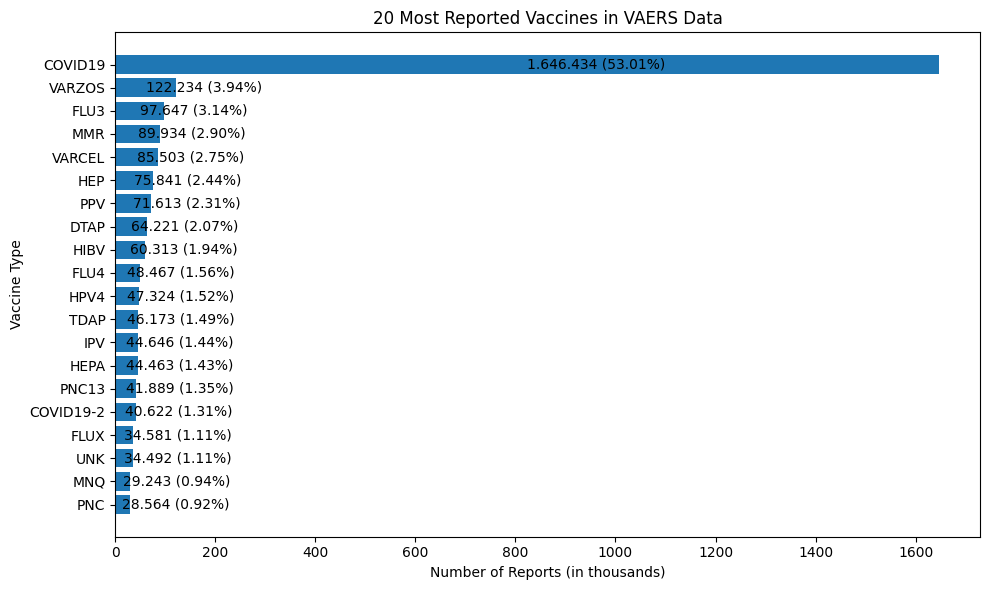

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale

# Set the locale to format numbers with thousands separator
locale.setlocale(locale.LC_ALL, '')

# MongoDB aggregation pipeline to count vaccine occurrences
pipeline = [
    {"$unwind": "$vax_data"},  # Unwind the vax_data array
    {"$group": {"_id": "$vax_data.VAX_TYPE", "count": {"$sum": 1}}},  # Group by VAX_TYPE and count occurrences
    {"$sort": {"count": -1}}  # Sort by count in descending order
]

# Execute the aggregation pipeline to get counts for all vaccines
all_vaccine_counts = collection.aggregate(pipeline)

# Extract vaccine types and counts for all vaccines
all_vaccine_counts_dict = {vaccine['_id']: vaccine['count'] for vaccine in all_vaccine_counts}

# MongoDB aggregation pipeline to count vaccine occurrences for the top 20 most reported vaccines
pipeline_top_20 = pipeline + [{"$limit": 20}] 

# Execute the aggregation pipeline to get counts for the top 20 most reported vaccines
vaccine_counts = collection.aggregate(pipeline_top_20)

# Extract vaccine types and counts for the top 20 most reported vaccines
vaccine_types = []
vaccine_counts_list = []
for vaccine in vaccine_counts:
    vaccine_types.append(vaccine['_id'])
    vaccine_counts_list.append(vaccine['count'])

# Calculate total number of reports for all vaccines
total_reports_all_vaccines = sum(all_vaccine_counts_dict.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(range(1, len(vaccine_types) + 1), vaccine_counts_list)
plt.yticks(range(1, len(vaccine_types) + 1), vaccine_types)  # Set y-tick labels

plt.title('20 Most Reported Vaccines in VAERS Data')
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Vaccine Type')

plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent vaccine at the top

# Add numbers and percentages to the bars in thousands with a dot separator
for i, (count, vaccine_type) in enumerate(zip(vaccine_counts_list, vaccine_types)):
    formatted_count = locale.format_string('%.0f', count, grouping=True)
    formatted_count = formatted_count.replace(',', '.')  # Replace comma with dot
    percentage = (count / total_reports_all_vaccines) * 100
    plt.text(count / 2, i + 1, f'{formatted_count} ({percentage:.2f}%)', va='center', ha='left')

# Define a function to format x-axis ticks in thousands
def format_thousands(x, pos):
    return '{:.0f}'.format(x * 1e-3)

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20VaccinesWithPercentage.png')
plt.show()


In [7]:
# Define the aggregation pipeline
pipeline = [
    {
        "$unwind": "$vax_data"  # Deconstruct the vax_data array
    },
    {
        "$group": {
            "_id": "$vax_data.VAX_TYPE",  # Group by VAX_TYPE field within vax_data
            "count": {"$sum": 1}  # Count occurrences of each VAX_TYPE
        }
    },
    {
        "$sort": {"count": -1}  # Optionally sort by count in descending order
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Print the result
for doc in result:
    print(doc)

{'_id': 'COVID19', 'count': 1646434}
{'_id': 'VARZOS', 'count': 122234}
{'_id': 'FLU3', 'count': 97647}
{'_id': 'MMR', 'count': 89934}
{'_id': 'VARCEL', 'count': 85503}
{'_id': 'HEP', 'count': 75841}
{'_id': 'PPV', 'count': 71613}
{'_id': 'DTAP', 'count': 64221}
{'_id': 'HIBV', 'count': 60313}
{'_id': 'FLU4', 'count': 48467}
{'_id': 'HPV4', 'count': 47324}
{'_id': 'TDAP', 'count': 46173}
{'_id': 'IPV', 'count': 44646}
{'_id': 'HEPA', 'count': 44463}
{'_id': 'PNC13', 'count': 41889}
{'_id': 'COVID19-2', 'count': 40622}
{'_id': 'FLUX', 'count': 34581}
{'_id': 'UNK', 'count': 34492}
{'_id': 'MNQ', 'count': 29243}
{'_id': 'PNC', 'count': 28564}
{'_id': 'RV5', 'count': 25217}
{'_id': 'OPV', 'count': 24899}
{'_id': 'DTP', 'count': 24463}
{'_id': 'HPV9', 'count': 22019}
{'_id': 'MMRV', 'count': 20961}
{'_id': 'TD', 'count': 19126}
{'_id': 'MENB', 'count': 14245}
{'_id': 'DTAPIPV', 'count': 13643}
{'_id': 'DTAPHEPBIP', 'count': 12590}
{'_id': 'DTAPIPVHIB', 'count': 12495}
{'_id': 'RV1', 'count

In [8]:
# Aggregate unique VAX_TYPE values
pipeline = [
    {
        "$unwind": "$vax_data"  # Deconstruct the vax_data array
    },
    {
        "$group": {
            "_id": "$vax_data.VAX_TYPE"  # Group by VAX_TYPE field within vax_data
        }
    },
    {
        "$group": {
            "_id": None,
            "count": {"$sum": 1}  # Count the number of unique VAX_TYPE values
        }
    }
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Extract the count of unique VAX_TYPE values
num_unique_vax_types = result[0]["count"] if result else 0

print("Number of different VAX_TYPES:", num_unique_vax_types)

Number of different VAX_TYPES: 101


In [10]:
# Aggregate unique VAX_TYPE values
pipeline = [
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"}  # Filter documents where VAX_TYPE array includes COVID
        }
    },
    {
        "$unwind": "$vax_data"  # Deconstruct the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID"}  # Filter documents where VAX_TYPE contains COVID
        }
    },
    {
        "$group": {
            "_id": "$vax_data.VAX_TYPE"  # Group by VAX_TYPE field within vax_data
        }
    },
    {
        "$group": {
            "_id": None,
            "count": {"$sum": 1}  # Count the number of unique VAX_TYPE values
        }
    }
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Extract the count of unique VAX_TYPE values
num_unique_vax_types = result[0]["count"] if result else 0

print("Number of different VAX_TYPES with at least one COVID vaccine:", num_unique_vax_types)

Number of different VAX_TYPES with at least one COVID vaccine: 2


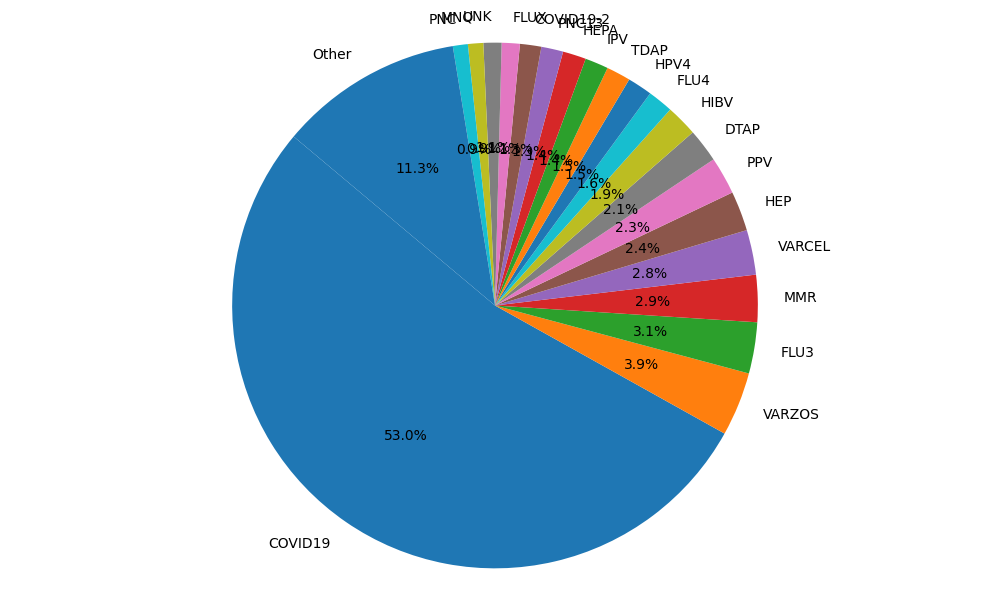

In [51]:
import matplotlib.pyplot as plt
import locale

# Set the locale to format numbers with thousands separator
locale.setlocale(locale.LC_ALL, '')

# MongoDB aggregation pipeline to count vaccine occurrences
pipeline = [
    {"$unwind": "$vax_data"},  # Unwind the vax_data array
    {"$group": {"_id": "$vax_data.VAX_TYPE", "count": {"$sum": 1}}},  # Group by VAX_TYPE and count occurrences
    {"$sort": {"count": -1}}  # Sort by count in descending order
]

# Execute the aggregation pipeline to get counts for all vaccines
all_vaccine_counts = collection.aggregate(pipeline)

# Extract vaccine types and counts for all vaccines
vaccine_types = []
vaccine_counts_list = []
for vaccine in all_vaccine_counts:
    vaccine_types.append(vaccine['_id'])
    vaccine_counts_list.append(vaccine['count'])

# Get the top 20 vaccines
top_20_vaccine_types = vaccine_types[:20]
top_20_vaccine_counts = vaccine_counts_list[:20]

# Calculate the count for the "Other" category
other_count = sum(vaccine_counts_list[20:])

# Combine the top 20 vaccines and "Other" category
combined_vaccine_types = top_20_vaccine_types + ['Other']
combined_vaccine_counts = top_20_vaccine_counts + [other_count]

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(combined_vaccine_counts, labels=combined_vaccine_types, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
#plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20AndOtherPieChart.png')
plt.show()


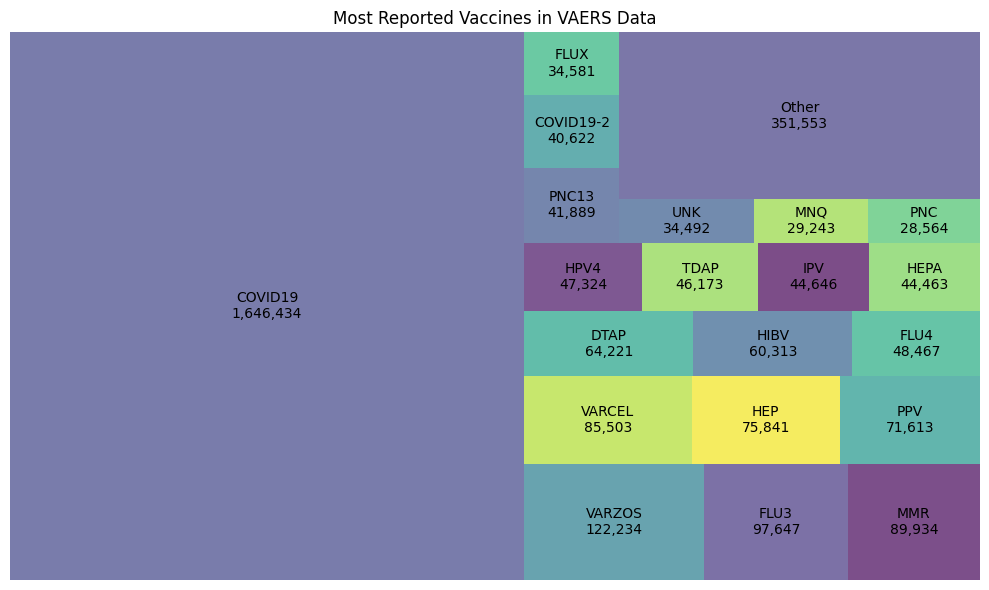

In [49]:
import matplotlib.pyplot as plt
import squarify
import locale

# Set the locale to format numbers with thousands separator
locale.setlocale(locale.LC_ALL, '')

# MongoDB aggregation pipeline to count vaccine occurrences
pipeline = [
    {"$unwind": "$vax_data"},  # Unwind the vax_data array
    {"$group": {"_id": "$vax_data.VAX_TYPE", "count": {"$sum": 1}}},  # Group by VAX_TYPE and count occurrences
    {"$sort": {"count": -1}}  # Sort by count in descending order
]

# Execute the aggregation pipeline to get counts for all vaccines
all_vaccine_counts = collection.aggregate(pipeline)

# Extract vaccine types and counts for all vaccines
vaccine_types = []
vaccine_counts_list = []
for vaccine in all_vaccine_counts:
    vaccine_types.append(vaccine['_id'])
    vaccine_counts_list.append(vaccine['count'])

# Get the top 20 vaccines
top_20_vaccine_types = vaccine_types[:20]
top_20_vaccine_counts = vaccine_counts_list[:20]

# Calculate the count for the "Other" category
other_count = sum(vaccine_counts_list[20:])

# Combine the top 20 vaccines and "Other" category
combined_vaccine_types = top_20_vaccine_types + ['Other']
combined_vaccine_counts = top_20_vaccine_counts + [other_count]

# Normalize counts for better visualization
total_count = sum(combined_vaccine_counts)
sizes = [(count / total_count) * 100 for count in combined_vaccine_counts]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the hierarchical tree map with labels
squarify.plot(sizes=sizes, label=[f'{vt}\n{locale.format_string("%.0f", ct, grouping=True)}' for vt, ct in zip(combined_vaccine_types, combined_vaccine_counts)], alpha=0.7)

plt.axis('off')
plt.title('Most Reported Vaccines in VAERS Data')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20VaccinesHierarchicalTreeMap.png')
plt.show()


/var/folders/5g/yyzx5_551v1dz53h3hnm2nmw0000gn/T/ipykernel_48274/1232390662.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


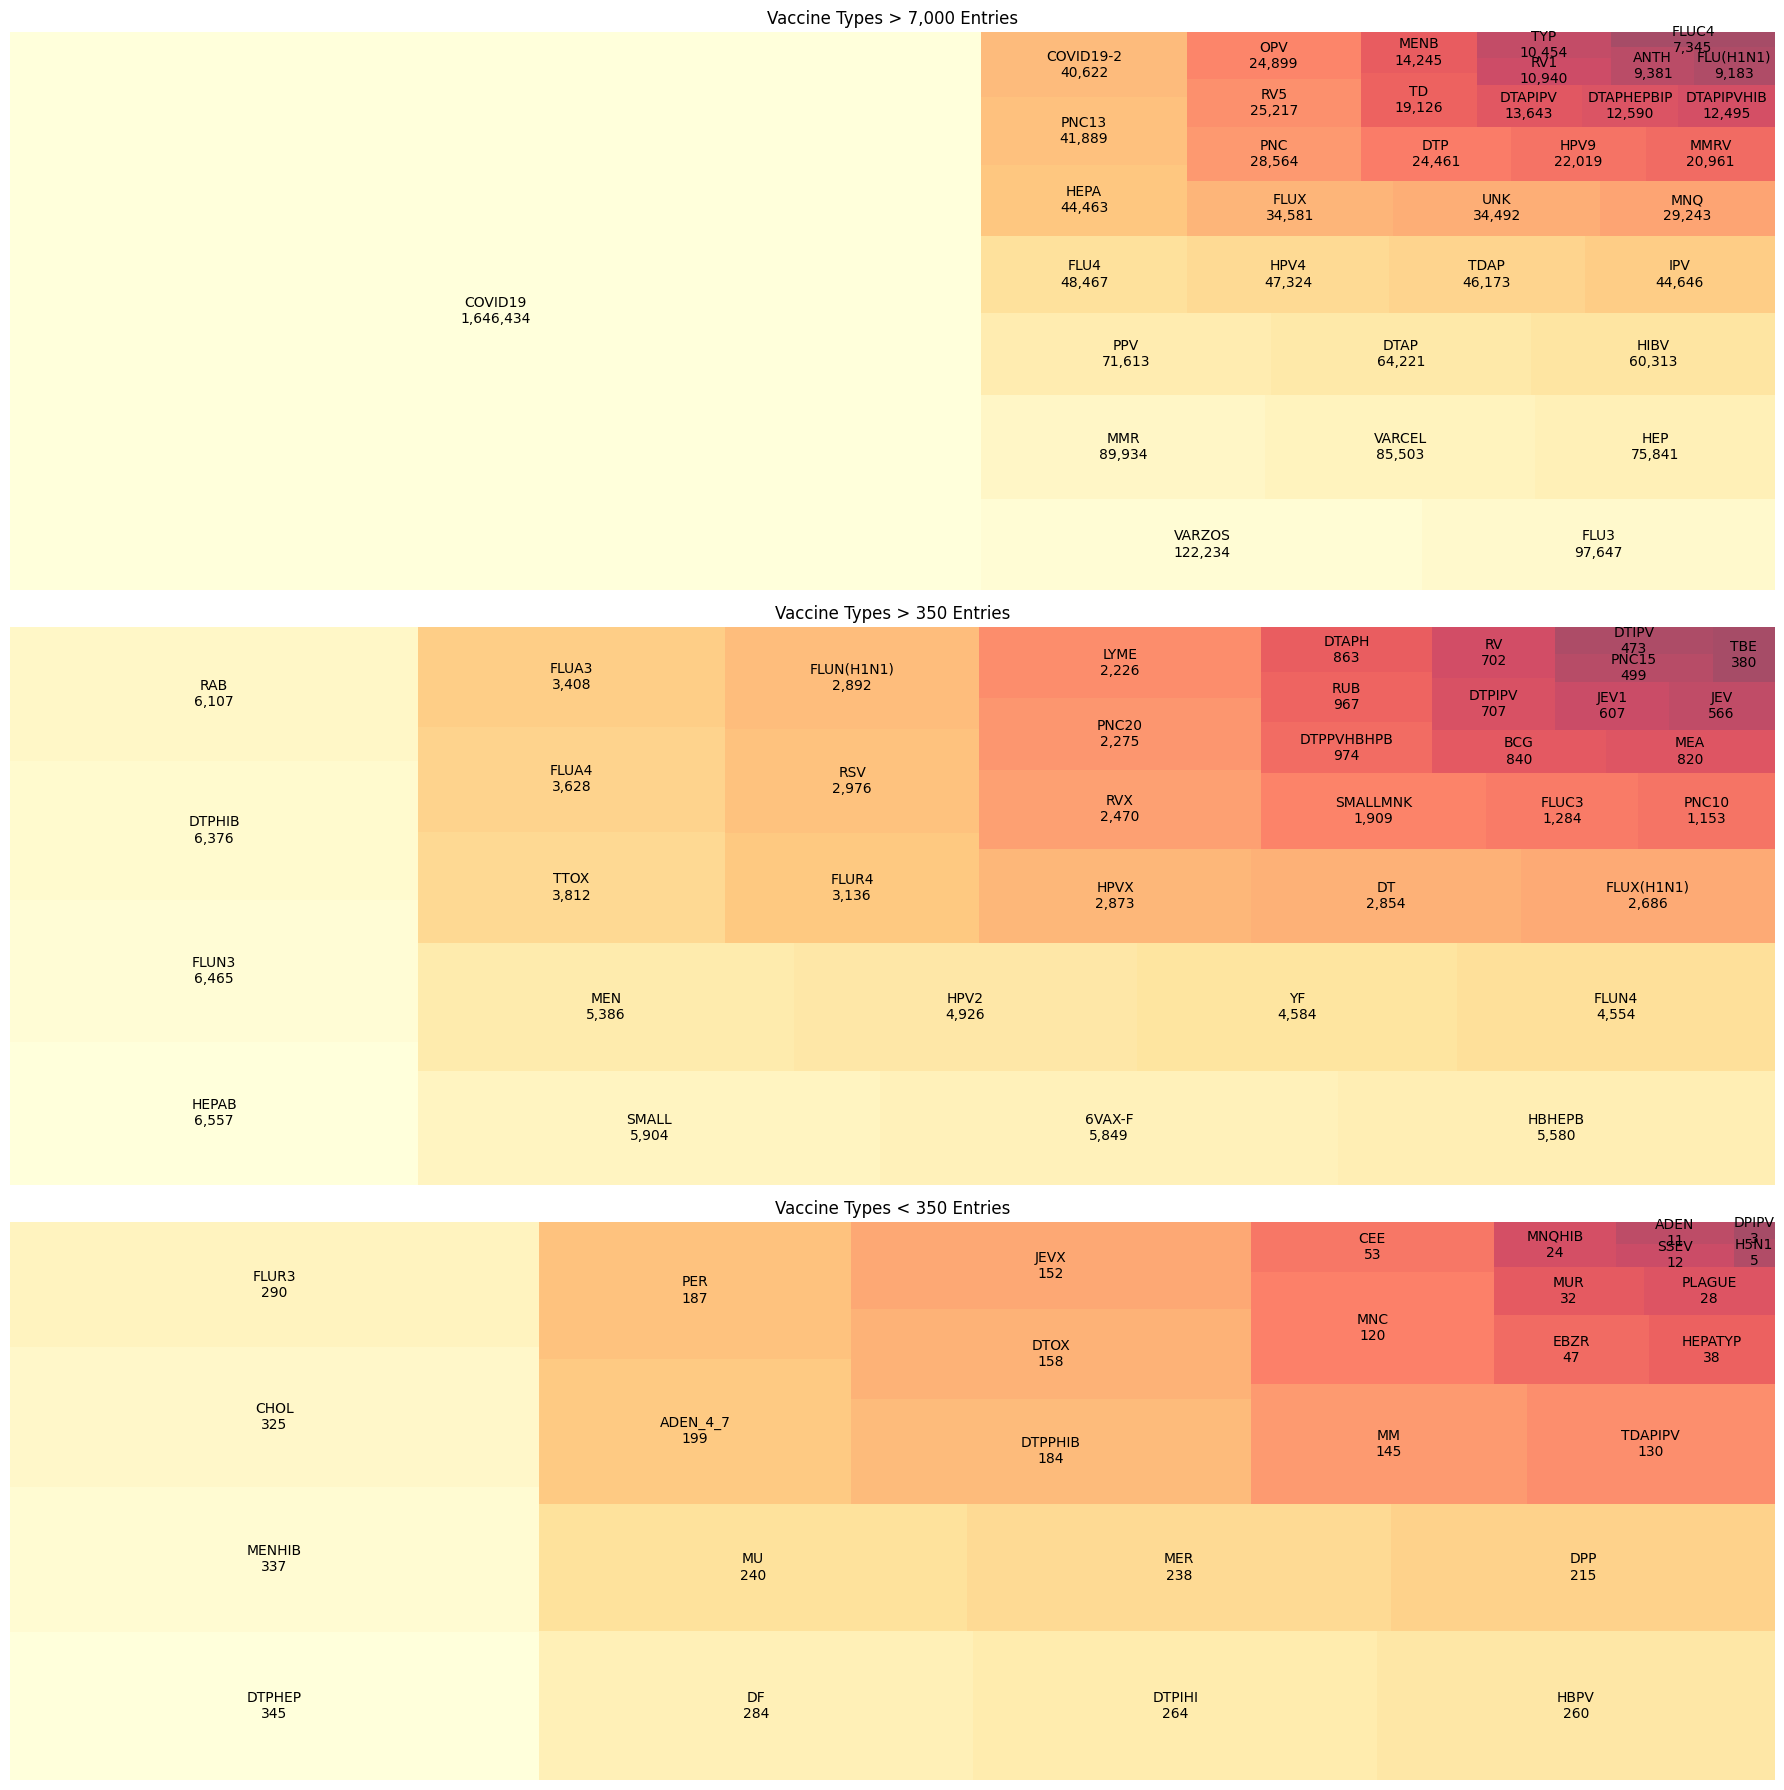

In [45]:
import matplotlib.pyplot as plt
import squarify
import locale
import numpy as np
import matplotlib.colors as mcolors

# Set the locale to format numbers with thousands separator
locale.setlocale(locale.LC_ALL, '')

# MongoDB aggregation pipeline to count vaccine occurrences
pipeline = [
    {"$unwind": "$vax_data"},  # Unwind the vax_data array
    {"$group": {"_id": "$vax_data.VAX_TYPE", "count": {"$sum": 1}}},  # Group by VAX_TYPE and count occurrences
    {"$sort": {"count": -1}}  # Sort by count in descending order
]

# Execute the aggregation pipeline to get counts for all vaccines
all_vaccine_counts = collection.aggregate(pipeline)

# Extract vaccine types and counts for all vaccines
vaccine_types = []
vaccine_counts_list = []
for vaccine in all_vaccine_counts:
    vaccine_types.append(vaccine['_id'])
    vaccine_counts_list.append(vaccine['count'])

# Normalize counts for better visualization
total_count = sum(vaccine_counts_list)
sizes = [(count / total_count) * 100 for count in vaccine_counts_list]

# Divide vaccine types into three groups based on count
threshold_large = 7000
threshold_medium = 350

large_vaccine_types = []
large_vaccine_counts_list = []
medium_vaccine_types = []
medium_vaccine_counts_list = []
small_vaccine_types = []
small_vaccine_counts_list = []

for vaccine_type, count in zip(vaccine_types, vaccine_counts_list):
    if count >= threshold_large:
        large_vaccine_types.append(vaccine_type)
        large_vaccine_counts_list.append(count)
    elif threshold_medium <= count < threshold_large:
        medium_vaccine_types.append(vaccine_type)
        medium_vaccine_counts_list.append(count)
    else:
        small_vaccine_types.append(vaccine_type)
        small_vaccine_counts_list.append(count)

# Define the colormap
cmap = plt.cm.get_cmap('YlOrRd')

# Plotting
plt.figure(figsize=(18, 18))

# Define a function to handle label display based on rectangle size
def display_label(vaccine_type, count):
    return f'{vaccine_type}\n{locale.format_string("%.0f", count, grouping=True)}'

# Plot for large vaccine types
plt.subplot(3, 1, 1)
squarify.plot(sizes=large_vaccine_counts_list, label=[display_label(vt, ct) for vt, ct in zip(large_vaccine_types, large_vaccine_counts_list)], alpha=0.7, color=cmap(np.linspace(0, 1, len(large_vaccine_types))))
plt.title('Vaccine Types > 7,000 Entries')
plt.axis('off')

# Plot for medium vaccine types
plt.subplot(3, 1, 2)
squarify.plot(sizes=medium_vaccine_counts_list, label=[display_label(vt, ct) for vt, ct in zip(medium_vaccine_types, medium_vaccine_counts_list)], alpha=0.7, color=cmap(np.linspace(0, 1, len(medium_vaccine_types))))
plt.title('Vaccine Types > 350 Entries')
plt.axis('off')

# Plot for small vaccine types
plt.subplot(3, 1, 3)
squarify.plot(sizes=small_vaccine_counts_list, label=[display_label(vt, ct) for vt, ct in zip(small_vaccine_types, small_vaccine_counts_list)], alpha=0.7, color=cmap(np.linspace(0, 1, len(small_vaccine_types))))
plt.title('Vaccine Types < 350 Entries')
plt.axis('off')

plt.tight_layout()
plt.show()
